In [84]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler

### Seasonality

Data is collected at 5 minute intervals over a 10 day timespan

Frequency = Number of observations per _season_ or _cycle_

Season = Hour, Day, Week, Month, Quarter, Year

_Note_: In Fourier analysis, “period” is the length of the cycle, and “frequency” is the inverse of period

Daily seasonality frequency of $288 = (24 * 60) / 5$

Day of week seasonality frequency of $2016 = (288 * 7)$

Work Week seasonality frequency of $1440 = (288 * 5)$

In [2]:
sigma_line = query_table(table='uv_sigma_line_eg_15T')

In [3]:
px.line(data_frame=sigma_line, x=sigma_line.index, y='p')

### Scale $X$ between [0-1] and use double precision

In [6]:
sigma_line.shape

(568, 8)

In [87]:
sigma_line = sigma_line[sigma_line.index.day >= 12] ## for pedagoical reasons

time_int_range = np.arange(0, 568*5, 5)
sigma_line['t'] = time_int_range

X = (sigma_line['t'].values - np.min(sigma_line['t'].values)) / (np.max(sigma_line['t'].values) - np.min(sigma_line['t'].values))
y = sigma_line['kw'].values

n = len(X)

prop_train = 0.85
n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

y_train_mean = np.mean(y_train)
y_train_std = np.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)

X_test = X
y_test = y[n_train:]
y_test = (y_test - y_train_mean) / (y_train_std)

In [88]:
px.line(x=X_train, y=y_train)

In [89]:
kernel = ConstantKernel() + RBF() * ExpSineSquared()

In [91]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
gp.fit(X_train.reshape(-1, 1), y_train)

GaussianProcessRegressor(kernel=1**2 + RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=1),
                         n_restarts_optimizer=5)

In [92]:
mean_preds, std_preds = gp.predict(X_test.reshape(-1, 1), return_std=True)

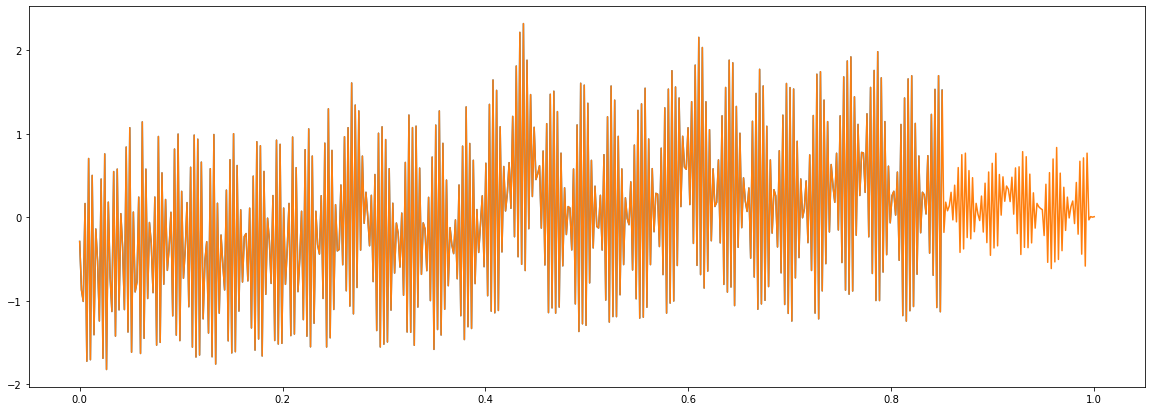

In [93]:
plt.figure(figsize=(20, 7))
plt.plot(X_train, y_train)
plt.plot(X_test, mean_preds)
plt.show()